In [1]:
from plotnine import *

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
%load_ext edx_jupyter

In [4]:
%reload_ext edx_jupyter

In [5]:
%vertica SELECT 'Connected to Vertica'

,?column?
0,Connected to Vertica


# Bookings per enrollment by pacing type for all courses

Look at all courses that started after 2014-01-01 and whose verification deadline is in the past. Look at the average bookings per enrollment by year.

In [6]:
%%vertica -> df_all
SELECT
    cm.pacing_type,
    YEAR(cm.course_start_date) AS starting_year,
    COUNT(*) AS num_courses,
    SUM(sum_bookings) / SUM(sum_enrolls_vtr) AS bookings_per_enrollment,
    SUM(sum_verifications) / SUM(sum_enrolls_vtr) AS vtr
FROM
    business_intelligence.course_stats_summary css
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = css.course_id
JOIN
    production.d_course c
    ON c.course_id = css.course_id
WHERE
    -- Odd that we have courses in our catalog without a pacing type?
    cm.pacing_type IS NOT NULL
    
    -- Exclude courses that didn't have a verified track
    AND cm.course_verification_end_date IS NOT NULL
    
    -- Look for courses whose deadline has already passed
    AND cm.has_verification_deadline_passed = 1
    
    -- Exclude courses that are starting in the future
    AND cm.course_start_date BETWEEN '2014-01-01' AND NOW()
    
    -- Exclude white label courses
    AND cm.is_WL = 0
GROUP BY 1, 2
ORDER BY 1 ASC, 2 ASC

Frustratingly, bookings_per_enrollment is an "object" type in the dataframe which we can't chart properly. Coerce it to a float.

In [7]:
df_all['bookings_per_enrollment'] = df_all.bookings_per_enrollment.astype(float)

In [8]:
df_all.set_index(['pacing_type', 'starting_year'])

num_courses  bookings_per_enrollment  \
pacing_type      starting_year                                         
instructor_paced 2014                   106                 0.792714   
                 2015                   509                 0.786355   
                 2016                   607                 1.298947   
                 2017                   304                 2.066328   
self_paced       2014                    11                 0.556667   
                 2015                   111                 0.430658   
                 2016                   282                 0.842352   
                 2017                   143                 1.951440   

                                                 vtr  
pacing_type      starting_year                        
instructor_paced 2014           0.015181762479691106  
                 2015           0.014365392891755913  
                 2016           0.021526601256480763  
                 2017           0.026488229088295498  
self_paced       2014           0.005692014227744713  
                 2015           0.007407702710842199  
                 2016           0.018184509066851775  
                 2017           0.035638848935335593

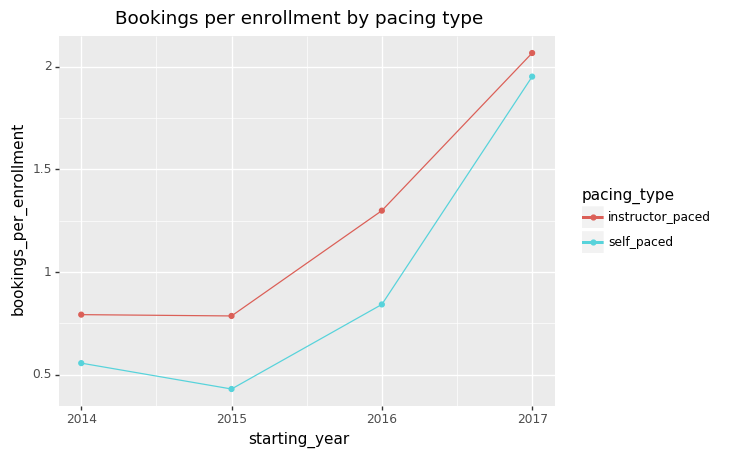

<ggplot: (8760267311168)>

In [9]:
(
    ggplot(
        df_all,
        aes(
            x='starting_year',
            y='bookings_per_enrollment',
            color='pacing_type'
        )
    )
    + geom_line()
    + geom_point()
    + ggtitle('Bookings per enrollment by pacing type')
)

This chart makes it look like self-paced has actually caught up to instructor paced recently. However, we know that Microsoft is a self-paced outlier, so let's remove it from our analysis.

# Break out Microsoft into its own category

In [10]:
%%vertica -> df
SELECT
    CASE WHEN c.org_id = 'Microsoft' THEN cm.pacing_type || '_msft'
         ELSE cm.pacing_type END AS pacing_type,
    YEAR(cm.course_start_date) AS starting_year,
    COUNT(*) AS num_courses,
    SUM(sum_bookings) / SUM(sum_enrolls_vtr) AS bookings_per_enrollment,
    SUM(sum_verifications) / SUM(sum_enrolls_vtr) AS vtr
FROM
    business_intelligence.course_stats_summary css
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = css.course_id
JOIN
    production.d_course c
    ON c.course_id = css.course_id
WHERE
    cm.pacing_type IS NOT NULL
    AND cm.course_verification_end_date IS NOT NULL
    AND cm.has_verification_deadline_passed = 1
    AND cm.course_start_date BETWEEN '2014-01-01' AND NOW()
    AND cm.is_WL = 0
GROUP BY 1, 2
ORDER BY 1 ASC, 2 ASC

In [11]:
df['bookings_per_enrollment'] = df.bookings_per_enrollment.astype(float)

In [12]:
df.set_index(['pacing_type', 'starting_year'])

num_courses  bookings_per_enrollment  \
pacing_type           starting_year                                         
instructor_paced      2014                   106                 0.792714   
                      2015                   473                 0.789406   
                      2016                   570                 1.322608   
                      2017                   303                 2.066919   
instructor_paced_msft 2015                    36                 0.743901   
                      2016                    37                 0.723931   
                      2017                     1                 1.126573   
self_paced            2014                    11                 0.556667   
                      2015                    99                 0.418202   
                      2016                   193                 0.676949   
                      2017                    40                 1.053264   
self_paced_msft       2015                    12                 0.514427   
                      2016                    89                 1.169945   
                      2017                   103                 2.417721   

                                                      vtr  
pacing_type           starting_year                        
instructor_paced      2014           0.015181762479691106  
                      2015           0.014568936902139473  
                      2016           0.021774963590861476  
                      2017           0.026496461250397447  
instructor_paced_msft 2015           0.011533526240548408  
                      2016           0.015490832365156311  
                      2017           0.013386880856760375  
self_paced            2014           0.005692014227744713  
                      2015           0.007154241524963938  
                      2016           0.011758213858461804  
                      2017           0.014179335109122750  
self_paced_msft       2015           0.009112364628492041  
                      2016           0.030912342469349780  
                      2017           0.046779381317279263

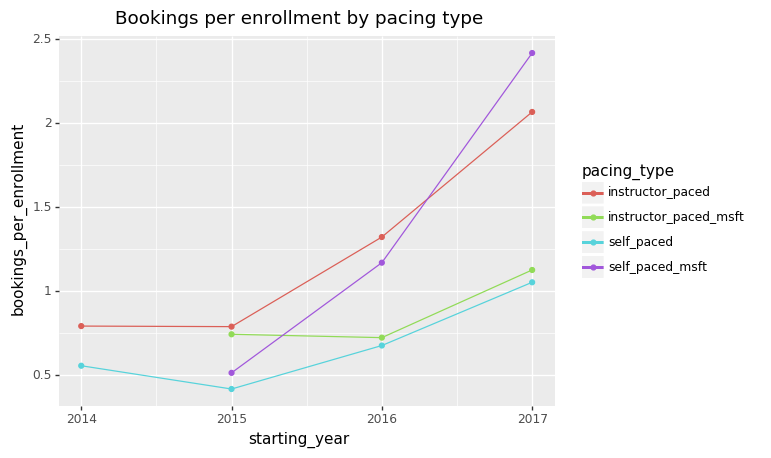

<ggplot: (8760267311294)>

In [13]:
(
    ggplot(
        df,
        aes(
            x='starting_year',
            y='bookings_per_enrollment',
            color='pacing_type'
        )
    )
    + geom_line()
    + geom_point()
    + ggtitle('Bookings per enrollment by pacing type')
)

It now becomes clear how much of an anomaly Microsoft is. Self paced clearly lags behind instructor paced by a very large margin. Looks like instructor paced pulls in roughly 2x the revenue of self-paced.

# Look at these metrics for MicroMasters courses (excluding MITx)

In [14]:
%%vertica -> df_mm
SELECT
    cm.pacing_type,
    CASE WHEN mm_courses.course_id IS NOT NULL THEN 1 ELSE 0 END AS is_micro_masters,
    COUNT(*) AS num_courses,
    SUM(sum_bookings) / SUM(sum_enrolls_vtr) AS bookings_per_enrollment,
    SUM(sum_verifications) / SUM(sum_enrolls_vtr) AS vtr
FROM
    business_intelligence.course_stats_summary css
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = css.course_id
JOIN
    production.d_course c
    ON c.course_id = css.course_id
LEFT JOIN
-- This query gets a list of all of the course_ids that are in MicroMasters programs
(
    SELECT DISTINCT
        course_id
    FROM
        production.d_program_course
    WHERE
        program_type='MicroMasters'
) mm_courses
    ON mm_courses.course_id = css.course_id
WHERE
    cm.pacing_type IS NOT NULL
    AND cm.course_verification_end_date IS NOT NULL
    AND cm.has_verification_deadline_passed = 1
    AND cm.course_start_date BETWEEN '2016-01-01' AND NOW()
    AND c.org_id != 'MITx'
    AND cm.is_WL = 0
GROUP BY 1, 2
ORDER BY 1 ASC, 2 ASC

In [15]:
df_mm

,pacing_type,is_micro_masters,num_courses,bookings_per_enrollment,vtr
0,instructor_paced,0,732,0.95363874452589502037,0.020356605493333251
1,instructor_paced,1,59,1.96113459782051121649,0.014159170242846598
2,self_paced,0,402,1.13535414393679794520,0.023131840021986977
3,self_paced,1,11,0.57590847084030180885,0.008423827176669159


The effect is even more pronounced in MicroMasters courses (excluding MITx). Instructor paced courses are roughly 4x better than self paced!

# Engagement by pacing type

In [16]:
%%vertica
SELECT
    CASE WHEN c.org_id = 'Microsoft' THEN cm.pacing_type || '_msft'
         ELSE cm.pacing_type END AS pacing_type,
    YEAR(cm.course_start_date) AS starting_year,
    COUNT(*) AS num_courses,
    SUM(sum_bookings) / SUM(sum_enrolls_vtr) AS bookings_per_enrollment,
    SUM(sum_verifications) / SUM(sum_enrolls_vtr) AS vtr,
    SUM(a.sum_users) / SUM(sum_enrolls) AS engaged_enrollments_ratio
FROM
    business_intelligence.course_stats_summary css
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = css.course_id
JOIN
    production.d_course c
    ON c.course_id = css.course_id
LEFT JOIN
(
    SELECT
        course_id,
        SUM(cnt_users) AS sum_users
    FROM
        business_intelligence.user_activity_engagement_weekly_agg
    WHERE
        weekly_engagement_level != 'no_engagement'
    GROUP BY 1
) a
    ON a.course_id = css.course_id
WHERE
    cm.pacing_type IS NOT NULL
    AND cm.course_verification_end_date IS NOT NULL
    AND cm.has_verification_deadline_passed = 1
    AND cm.course_start_date BETWEEN '2014-01-01' AND NOW()
    AND YEAR(cm.course_start_date) = 2016
    AND cm.is_WL = 0
GROUP BY 1, 2
ORDER BY 1 ASC, 2 ASC

,pacing_type,starting_year,num_courses,bookings_per_enrollment,vtr,engaged_enrollments_ratio
0,instructor_paced,2016,570,1.32260761783033955059,0.021774963590861476,0.336938003153958340
1,instructor_paced_msft,2016,37,0.72393084322654452056,0.015490832365156311,0.211370292960148752
2,self_paced,2016,193,0.67694930093539651612,0.011758213858461804,0.381547003530019814
3,self_paced_msft,2016,89,1.16994539458686293342,0.030912342469349780,0.402691921787436067


Here we can see that self-paced engagement actually looks like it's very similar to instructor paced.

# Comparing MITx and Microsoft

MIT is another very strong brand that tends to be an outlier. Compare it to Microsoft.

In [17]:
%%vertica -> df_hv
SELECT
    c.org_id,
    cm.pacing_type,
    YEAR(cm.course_start_date) AS starting_year,
    COUNT(*) AS num_courses,
    SUM(sum_bookings) / SUM(sum_enrolls_vtr) AS bookings_per_enrollment,
    SUM(sum_verifications) / SUM(sum_enrolls_vtr) AS vtr
FROM
    business_intelligence.course_stats_summary css
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = css.course_id
JOIN
    production.d_course c
    ON c.course_id = css.course_id
WHERE
    cm.pacing_type IS NOT NULL
    AND cm.course_verification_end_date IS NOT NULL
    AND cm.has_verification_deadline_passed = 1
    AND cm.course_start_date BETWEEN '2014-01-01' AND NOW()
    AND c.org_id IN ('Microsoft', 'MITx')
    AND cm.is_WL = 0
GROUP BY 1, 2, 3
ORDER BY 1 ASC, 2 ASC, 3 ASC

In [18]:
df_hv['bookings_per_enrollment'] = df_hv.bookings_per_enrollment.astype(float)

In [19]:
df_hv.set_index(['org_id', 'pacing_type', 'starting_year'])

num_courses  \
org_id    pacing_type      starting_year                
MITx      instructor_paced 2014                    19   
                           2015                    57   
                           2016                    74   
                           2017                    46   
          self_paced       2015                    10   
                           2016                    10   
                           2017                     2   
Microsoft instructor_paced 2015                    36   
                           2016                    37   
                           2017                     1   
          self_paced       2015                    12   
                           2016                    89   
                           2017                   103   

                                          bookings_per_enrollment  \
org_id    pacing_type      starting_year                            
MITx      instructor_paced 2014                          1.717934   
                           2015                          1.535278   
                           2016                          3.076920   
                           2017                          4.633783   
          self_paced       2015                          0.713650   
                           2016                          1.035484   
                           2017                          0.990369   
Microsoft instructor_paced 2015                          0.743901   
                           2016                          0.723931   
                           2017                          1.126573   
          self_paced       2015                          0.514427   
                           2016                          1.169945   
                           2017                          2.417721   

                                                           vtr  
org_id    pacing_type      starting_year                        
MITx      instructor_paced 2014           0.029135160801172248  
                           2015           0.025265437258049691  
                           2016           0.036313960039535478  
                           2017           0.042578224874027916  
          self_paced       2015           0.009906064261295101  
                           2016           0.010694631917765549  
                           2017           0.015172720494944606  
Microsoft instructor_paced 2015           0.011533526240548408  
                           2016           0.015490832365156311  
                           2017           0.013386880856760375  
          self_paced       2015           0.009112364628492041  
                           2016           0.030912342469349780  
                           2017           0.046779381317279263

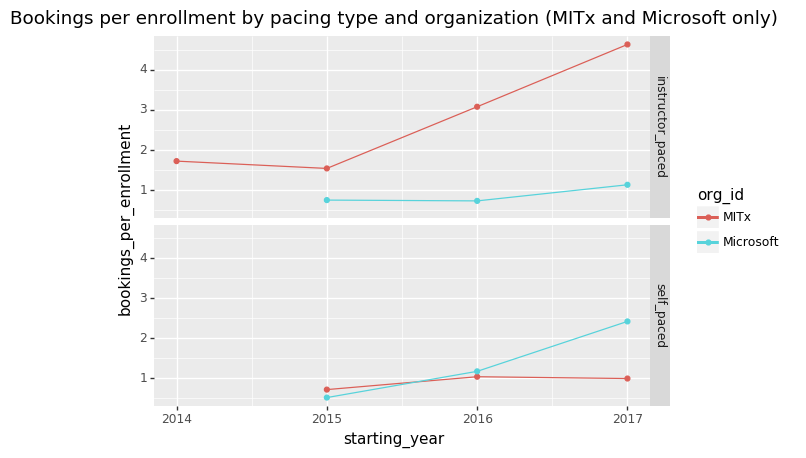

<ggplot: (8760264457273)>

In [20]:
(
    ggplot(
        df_hv,
        aes(
            x='starting_year',
            y='bookings_per_enrollment',
            color='org_id'
        )
    )
    + geom_line()
    + geom_point()
    + facet_grid('pacing_type ~ .')
    + ggtitle('Bookings per enrollment by pacing type and organization (MITx and Microsoft only)')
)

It looks like Microsoft outperforms MITx in self paced by a pretty wide margin.

# Look at sustained engagement over time

Do users who start the course stick with it?

In [21]:
%%vertica -> df_eng

SELECT
    cm.pacing_type,
    SPLIT_PART(e.week, '_', 2)::INT AS week,
    SUM(e.cnt_users) AS cnt_users,
    SUM(e.cnt_users) / SUM(week_1_engaged_users.cnt_users) AS relative_to_week_1
FROM
    business_intelligence.user_activity_engagement_weekly_agg e
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = e.course_id
JOIN
    (
        SELECT
            course_id,
            cnt_users
        FROM
            business_intelligence.user_activity_engagement_weekly_agg
        WHERE
            weekly_engagement_level != 'no_engagement'
            AND week = 'week_1'
    ) week_1_engaged_users
    ON week_1_engaged_users.course_id = e.course_id
WHERE
    e.weekly_engagement_level != 'no_engagement'
    AND e.week != 'week_1'
GROUP BY 1, 2
ORDER BY 1, 2

In [22]:
df_eng['cnt_users'] = df_eng.cnt_users.astype(int)
df_eng['relative_to_week_1'] = df_eng.relative_to_week_1.astype(float)

In [23]:
df_eng

,pacing_type,week,cnt_users,relative_to_week_1
0,instructor_paced,2,1686718,0.132162
1,instructor_paced,3,1251570,0.098755
2,instructor_paced,4,984266,0.078047
3,instructor_paced,5,778205,0.062493
4,self_paced,2,1282094,0.082320
5,self_paced,3,838624,0.054165
6,self_paced,4,603266,0.039132
7,self_paced,5,458842,0.029954


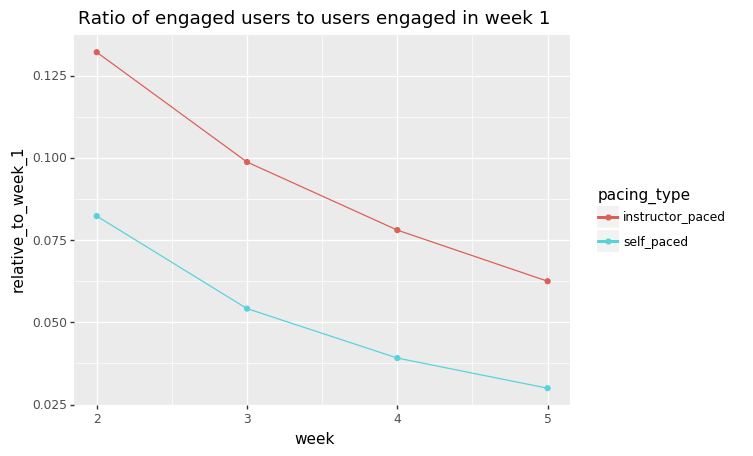

<ggplot: (8760264185629)>

In [24]:
(
    ggplot(
        df_eng,
        aes(
            x='week',
            y='relative_to_week_1',
            color='pacing_type'
        )
    )
    + geom_line()
    + geom_point()
    + ggtitle('Ratio of engaged users to users engaged in week 1')
)